<a href="https://colab.research.google.com/github/Kobajojn/FYRP_U-Net_Architecture/blob/main/U_net_Architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
!pip install tacoreader rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 53.9 MB/s eta 0:00:00


Text(0.5, 1.0, 'Human label')

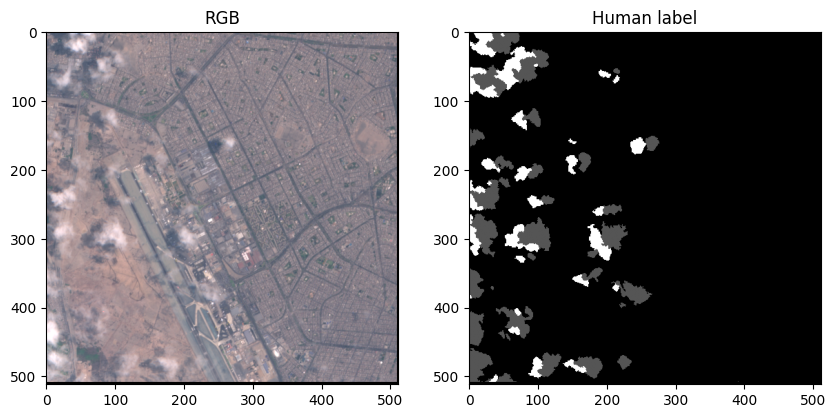

In [2]:
# @Setup and accessing CloudSEN12+
# REWRITE WHOLE SECTION - COPIED

import logging
import matplotlib.pyplot
import matplotlib.pyplot
import numpy
import tacoreader
import rasterio as rio
import torch
import torch.nn as nn

# initalise and set up the logger

# Select one image from the test dataset
ds = tacoreader.load("tacofoundation:cloudsen12-l1c")
subset = ds[(ds["tortilla:data_split"] == "test") & (ds["label_type"] == "high") & (ds["real_proj_shape"] == 509)] #splits the file into segments - rewrite - from tacoreader library

# Read only one sample
sample_idx = 271
s2_l1c = subset.read(sample_idx).read(0)
s2_label = subset.read(sample_idx).read(1)

# Retrieve the S2 data - EDIT TO BE MORE READABLE
with rio.open(s2_l1c), rio.open(s2_label):
    s2_l1c_data = rio.open(s2_l1c).read(window=rio.windows.Window(0, 0, 512, 512)) / 10_000   # (13, 512, 512) ndarray (numpy)
    s2_label_data = rio.open(s2_label).read(window=rio.windows.Window(0, 0, 512, 512))        #var is a string with links to hugging face

# Graphing image with human determined labels
datapoint_rgb = numpy.moveaxis(s2_l1c_data[[3, 2, 1]], 0, -1) * 3  #REWRITE - ensure that the dimensionality exploited is the colour channels #TODO understand technique
fig, ax = matplotlib.pyplot.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(datapoint_rgb)
ax[0].set_title("RGB")
ax[1].imshow(s2_label_data[0], cmap="gray")
ax[1].set_title("Human label")

In [3]:
# set up logger application
logger = logging.getLogger(__name__)

logging.basicConfig(
    #filename = "logging.txt",  # logger is saved to file instead of value
    encoding = "ASCII",
    format = "%(asctime)s %(name)s %(levelname)s:\t%(message)s",
    level = logging.INFO,
    force = True
)

# Misc Functions

In [4]:
def tensor_info(tensor_input, tensor_name):
  """
  Prints off a list of the tensor's details including:  \
    Datatype, Shape, Size, and the device location stored in memory

  foward() Args:
    tensor_input (tensor) - tensor to be examined.
    tensor_name (string) - a string description of the tensor used for descriptive purposes

  return:
    None
  """
  logger.info(f"Tensor:\t\t\t{tensor_name}")
  logger.info(f"Output Datatype:\t{tensor_input.dtype}")
  logger.info(f"Output Shape:\t\t{tensor_input.shape}")
  logger.info(f"Output Size:\t\t{tensor_input.size()}")
  logger.info(f"Output Device:\t\t{tensor_input.device}"
      f"\n--------------------------------------------------------\n")
  return None

In [5]:
def mash_colour_channel(img):
  """
  Generate a greyscale image of a tensor with more than 3 colour/feature channels. \
    Use primarily for visualisation and debugging purposes of prior transformations.

  foward() Args:
    img (tensor) - The input image. Image format is [z, x, y] or [w, u, v]

  return:
    None
  """
  # Temporary - converts from Tensor to numpy - TODO: understand why detach is needed
  img = img.detach().numpy()
  z_size = img.shape[0] # Gathers the size of the z or colour element

  # averages out the colour channel elementwise - main transformation of function
  img_no_colour = numpy.mean(a = img, axis = 0)

  # display image dimension characterisitics and print the image
  logger.info(f"The image resolution is {img_no_colour.shape}")
  logger.info(f"The number of colour channels are {z_size}")
  matplotlib.pyplot.gray() # place the image output into greyscale
  matplotlib.pyplot.imshow(img_no_colour)
  matplotlib.pyplot.show()
  return None

# Encoder Layer

In [6]:
device = 'cpu'

# ENCODER LAYER - going "down the U"; i.e decreasing the resolution at the for more colour channels

class conv_layer(nn.Module):
  """
  Decreases the spatial resolution of the image for more colour/feature channels.
    Used in both encoder and decoder segments.
    Applies a convolution (3x3) and ReLU to the image twice to the image.
    1x convolution reduces the resolution by 2 pixels and 2x the colour channels.

  class() Args:
    channels_in (int) - The no. of colour/feature channels of the input img.
  foward() Args:
    img (tensor float32) - The input image. Image format is [z, x, y] or [w, u, v]

  return:
    output (tensor float32) - The output image after transformations.
  """
  def __init__ (self, channels_in, up_sample = True): # Parameters go here!
    super().__init__()

    if up_sample:
      out_channels = channels_in * 2
    else:
      out_channels = int(channels_in / 2)

    # Convolution 1 - a sliding window function
    self.conv1 = nn.Conv2d(
        in_channels = channels_in,
        out_channels = out_channels,
        kernel_size = 3,
        stride = 1,
        # padding = 1,                    # padded with zeros to ensure dimensions are always even
        # padding_mode = 'zeros',         # [30] recommends an unpadded convolution
        # bias = True # defaults to True - is a learned bias to Output
        dtype = torch.float32
    )
    # Convolution 2 - a sliding window function
    self.conv2 = nn.Conv2d(
        in_channels = out_channels,
        out_channels = out_channels,
        kernel_size = 3,
        stride = 1,
        dtype = torch.float32
    )
    # Rectified Linear Unit 1 - A non-linear activation function
    self.relu = nn.ReLU()

  def forward(self, img):
    output = self.conv1(img)
    output = self.relu(output)
    output = self.conv2(output)
    output = self.relu(output)
    return output


class encoder_layer(nn.Module):
  """
  Decreases the spatial resolution of the image for more colour/feature channels.
    Main core segment of the encoder stage.
    Applies a convolution (3x3) and ReLU to the image twice then (2x2) pool to the image.

    1x pooling downsamples the resolution by x0.5.

  class() Args:
    channels_in (int) - The no. of colour/feature channels of the input img.
  foward() Args:
    img (tensor float32) - The input image. Image format is [z, x, y] or [w, u, v]

  return:
    postpool_output (tensor float32) - The output image after pooling.
    prepool_output (tensor float32) - The output image before pooling. Used in concatenation.
  """
  def __init__ (self): # Parameters go here!
    super().__init__()

    # A 2x2 kernal is used, with a stride/offset of 2 pixels
    self.pooling = nn.MaxPool2d(
        kernel_size = (2, 2),
        stride = 2,
    )

  def forward(self, img, channels_in):
    conv_forward = conv_layer(channels_in = channels_in)
    output = conv_forward(img)

    prepool_output = output
    postpool_output = self.pooling(output) # Final transformation to image

    return postpool_output, prepool_output


# Decoder Layer

In [7]:
# DECODER LAYER - going "up the U"; i.e increasing the resolution at the expense of less colour channels

class decoder_layer(nn.Module):
  """
  Increases the spatial resolution of the image for less colour/feature channels.
    Apply a (2x2) "deconvolution" transformation to counteract the impacts of pooling and convolution.
    Then a "concatenation_feature()" is applied to double colour channel size.
    The main building block of the decoder side of the U-net model.
    1x deconvolution increases the resolution 2x and the colour channels by x0.5.
    1x "concatenation_features()" to the image (doubles colour channel)

  class() Args:
    channels_in (int) - The no. of colour/feature channels of the input img.

  crop_and_concat() Args:
    img_decoder (tensor float32) - Deconvoluted image from decoder side.
      Image format is [z, x, y] or [w, u, v].
      Only works if [x, y] dimensions are EVEN.
    img_encoder_skip (tensor float32) - Pooled image from encoder side. Larger than img_deconv
      Image format is [z, x, y] or [w, u, v]

  foward() Args:
    img (tensor) - The input image. Image format is [z, x, y] or [w, u, v]

  return:
    output (tensor) - The increased spatial resolution image.
  """
  def __init__ (self, channels_deconv_in):
    super().__init__()

    self.deconv1 = nn.ConvTranspose2d(
        in_channels = channels_deconv_in,
        out_channels = int(channels_deconv_in / 2),
        kernel_size = [2, 2], # Deconvolute the image with a 2x2 kernal
        stride = 2,           # to significantly increase the resolution
        dtype = torch.float32
    )

  def crop_and_concat(self, img_decoder, img_encoder_skip):
    """
    Doubles the feature channels of its input image.
      Crops prepool_output from the encoder layer and then concatenates its colour/
      feature channels with the decoder's respective deconvoluted image.

    Args:
      img_decoder (tensor float32) - Deconvoluted image from decoder side.
        Image format is [z, x, y] or [w, u, v].
        Only works if [x, y] dimensions are EVEN.
      img_encoder_skip (tensor float32) - Pooled image from encoder side. Larger than img_deconv
        Image format is [z, x, y] or [w, u, v]

    Returns:
      img_concat (tensor float32) - image with double the inputs colour channels
    """
    # Determining the range of the cropping
    size_difference =  img_encoder_skip.shape[1] - img_decoder.shape[1]
    logger.debug(f"size_difference = {size_difference}")
    logger.debug(f"img_encoder_skip.shape = {img_decoder.shape}")
    logger.debug(f"img_decoder.shape = {img_decoder.shape}")

    lower_range = int(size_difference / 2)
    upper_range = img_decoder.shape[1] + lower_range

    # Only works if dimensions are even
    if size_difference % 2 == 0:
      logger.debug(f"The image dimensions are EVEN. Thus cropping can be applied.")

      # Crop the encoded image to fit the resolution of the reduced (in dimensions) decoded image
      img_encoder_crop = img_encoder_skip[:, lower_range:upper_range, lower_range:upper_range]
      # tensor_info(img_decoder, "[ORIGINAL] img_decoder")
      # tensor_info(img_encoder_crop, "[CROPPED] img_encoder_crop")

      # concatenate the colour/feature channels of the encoder and decoder imgs.
      img_concat = torch.cat(tensors = (img_decoder, img_encoder_crop), dim = 0)
      # tensor_info(img_concat, "[COMBINED] img_concat (combined colour channels)")
      # mash_colour_channel(img_concat)

      return img_concat

    else:
      logger.info(f"The image dimensions are ODD. Thus cropped can NOT be applied."
        f"Please crop the image for a EVEN dimension.")
      return None

  def forward(self, img_decoder, img_encoder_skip, channels_in):
    # deconvolute (decrease features, increasing x,y size) + crop and concatenate (x2 feature channels)
    output = self.deconv1(img_decoder)
    output = self.crop_and_concat(img_decoder = output, img_encoder_skip = img_encoder_skip)

    # Apply 2x convolutions + 2x ReLU
    conv_layer_1 = conv_layer(channels_in = channels_in, up_sample = False)
    output = conv_layer_1(output)
    return output

# Bringing it all together

In [8]:
""" ---VARIABLE NAMING NOMENCLATURE:---
- Alphabetical images correspond to which layer the image was generated on.
e.g. B_pooled is on layer 2.
- "X_pooled" are images generated with 2x2 pooling applied.
- "X_concat" are images generated before pooling. This are for concatenation later.
"""

class u_net(nn.Module):
  """
  Increases the spatial resolution of the image for less colour/feature channels.
    Applies the U-net architecture complete via prior defined piecemeal functions.

  class() Args:
    channels_in (int) - The no. of colour/feature channels of the input img.

  crop_and_concat() Args:
    img_decoder (tensor float32) - Deconvoluted image from decoder side.
      Image format is [z, x, y] or [w, u, v].
      Only works if [x, y] dimensions are EVEN.

  foward() Args:
    img (tensor) - The input image. Image format is [z, x, y] or [w, u, v]

  return:
    output (tensor) - The increased spatial resolution image.
  """
  def __init__ (self, ):
    super().__init__()
    # ---------------------------------------------------------
    # Instantiate and initialise each layer
    # Encoder Layer instantiation
    self.encoder_layer_1 = encoder_layer().to(device)
    # Bottleneck Layer instantiation
    self.bottleneck_layer = conv_layer(channels_in = 208).to(device)
    # Decoders instantiation
    self.decoder_layer_0 = decoder_layer(channels_deconv_in = 416).to(device)
    self.decoder_layer_1 = decoder_layer(channels_deconv_in = 208).to(device)
    self.decoder_layer_2 = decoder_layer(channels_deconv_in = 104).to(device)
    self.decoder_layer_3 = decoder_layer(channels_deconv_in = 52).to(device)
    self.decoder_layer_4 = decoder_layer(channels_deconv_in = 26).to(device)
    # Final Layer instantiation
    self.final_layer = conv_layer(channels_in = 26, up_sample = False).to(device)
    # ---------------------------------------------------------

  def forward(self, img):

    # Apply image to instantiated layers
    # Encoder layer
    A_pooled, A_concat = self.encoder_layer_1(img, channels_in = 13)
    B_pooled, B_concat = self.encoder_layer_1(A_pooled, channels_in = 26)
    C_pooled, C_concat = self.encoder_layer_1(B_pooled, channels_in = 52)
    D_pooled, D_concat = self.encoder_layer_1(C_pooled, channels_in = 104)

    # Bottleneck layer
    E_bottleneck = self.bottleneck_layer(D_pooled)

    # Decoder Layer
    D_deconv = self.decoder_layer_0(
        img_decoder = E_bottleneck,
        img_encoder_skip = D_concat,
        channels_in = 416
    )
    C_deconv = self.decoder_layer_1(
        img_decoder = D_deconv,
        img_encoder_skip = C_concat,
        channels_in = 208
    )
    B_deconv = self.decoder_layer_2(
        img_decoder = C_deconv,
        img_encoder_skip = B_concat,
        channels_in = 104
    )
    A_deconv = self.decoder_layer_3(
        img_decoder = B_deconv,
        img_encoder_skip = A_concat,
        channels_in = 52
    )
    # Final Layer
    Final_output = self.final_layer(A_deconv)
    return Final_output

2025-10-06 18:51:57,241 __main__ INFO:	The image resolution is (320, 320)
2025-10-06 18:51:57,244 __main__ INFO:	The number of colour channels are 13


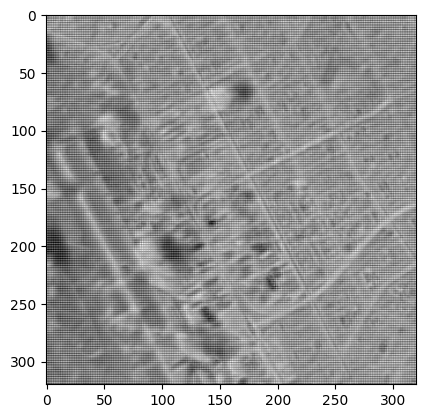

In [9]:
# Image preprocessing
s2_l1c_data_tensor = torch.from_numpy(s2_l1c_data)
s2_l1c_data_tensor = s2_l1c_data_tensor.to(torch.float32)
s2_l1c_data_tensor = s2_l1c_data_tensor.to(device)
# Crop image such that after 8 convolutions are 4 poolings, the dimensions are always even
s2_l1c_data_tensor = s2_l1c_data_tensor[:, 0:508, 0:508]

# Apply everything via the U-net architecture
u_net_arch = u_net()
img_out = u_net_arch(s2_l1c_data_tensor)

mash_colour_channel(img_out)

# Training Stage Sandpit

In [10]:
# Sandpit - for debugging and troubleshooting

# Seed for randomness - keeps the initial parameter values consistent
torch.manual_seed(27)

# Sanity Check: Display u-net architecture's parameters
u_net_arch_0 = u_net()
logger.debug(f"{list(u_net_arch_0.parameters()) = }")

# Training Stage

In [11]:
# PLACEHOLDER REMOVE ONCE OBSOLETE

# # Select one image from the test dataset
# ds = tacoreader.load("tacofoundation:cloudsen12-l1c")
# subset = ds[(ds["tortilla:data_split"] == "test") & (ds["label_type"] == "high") & (ds["real_proj_shape"] == 509)] #splits the file into segments - rewrite - from tacoreader library

# # Read only one sample
# sample_idx = 18
# s2_l1c = subset.read(sample_idx).read(0)   # string outlying the location of dataset
# s2_label = subset.read(sample_idx).read(1) # string outlying the location of dataset

# # Retrieve the S2 data - EDIT TO BE MORE READABLE
# # Builds the data into Colab
# with rio.open(s2_l1c), rio.open(s2_label):
#     s2_l1c_data = rio.open(s2_l1c).read(window=rio.windows.Window(0, 0, 512, 512)) / 10_000   # (13, 512, 512) ndarray (numpy)
#     s2_label_data = rio.open(s2_label).read(window=rio.windows.Window(0, 0, 512, 512))        #var is a string with links to hugging face

# # Graphing image with human determined labels
# datapoint_rgb = numpy.moveaxis(s2_l1c_data[[3, 2, 1]], 0, -1) * 3  #REWRITE - ensure that the dimensionality exploited is the colour channels #TODO understand technique
# fig, ax = matplotlib.pyplot.subplots(1, 2, figsize=(10, 5))
# ax[0].imshow(datapoint_rgb)
# ax[0].set_title("RGB")
# ax[1].imshow(s2_label_data[0], cmap="gray")
# ax[1].set_title("Human label")


In [12]:
# Preparation for auto iterating and downloading requesite data
l1c_fileNames = [
    "cloudsen12-l1c.0000.part.taco", # Installed - 2025.10.01
    "cloudsen12-l1c.0001.part.taco", # Installed - 2025.10.01
    "cloudsen12-l1c.0002.part.taco", # --
    "cloudsen12-l1c.0003.part.taco", # --
    "cloudsen12-l1c.0004.part.taco"  # --
  ]

from huggingface_hub import hf_hub_download
import os.path

# Searches for imported datasets. If none are found download
if os.path.isfile("/content/datasets/cloudsen12-l1c.0000.part.taco") == False:
  logger.info(f"The requisite datasets have not been installed.\n\t\t\t\t\t"
      "Please wait until the datasets is been installed from huggingface.\n\t\t\t\t\t"
      "This will take a long time approximately 5+ minutes")

  # 20GB download requires significant time - execute sparingly takes roughly 5 minutes to fully execute
  # Downloads data from huggingface and stores it in Colab file system which is reset on every startup
  dataset_0 = hf_hub_download(
      "tacofoundation/cloudsen12",
      "cloudsen12-l1c.0000.part.taco",
      repo_type = "dataset",
      revision = "f9490f7de11b4f387f72ef800e73ccbb754711de",
      local_dir = "/content/datasets" # Path to save dataset on Colab
  )
  logger.info(f"cloudsen12-l1c.0000.part.taco has been installed.")

  # dataset_1 = hf_hub_download(
  #     "tacofoundation/cloudsen12",
  #     "cloudsen12-l1c.0001.part.taco",
  #     repo_type = "dataset",
  #     revision = "f9490f7de11b4f387f72ef800e73ccbb754711de",
  #     local_dir = "/content/datasets" # Path to save dataset on Colab
  # )
  # logger.info(f"cloudsen12-l1c.0001.part.taco has been installed.")
  logger.info(f"The requisite datasets have been installed.")
else:
  logger.info(f"The requisite datasets have already been been installed.\n\t\t\t\t\t"
      "No further action is required.")
  # Ensure that the file is referenced in the local variable memory - TODO
  #with open("/content/datasets/cloudsen12-l1c.0000.part.taco") as file:
  #  exec(dataset1 = file)

2025-10-06 18:51:58,193 __main__ INFO:	The requisite datasets have not been installed.
					Please wait until the datasets is been installed from huggingface.
					This will take a long time approximately 5+ minutes
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


cloudsen12-l1c.0000.part.taco:   0%|          | 0.00/20.0G [00:00<?, ?B/s]

2025-10-06 18:56:14,983 __main__ INFO:	cloudsen12-l1c.0000.part.taco has been installed.
2025-10-06 18:56:14,984 __main__ INFO:	The requisite datasets have been installed.


In [13]:
DATA = tacoreader.load(file = ["/content/datasets/cloudsen12-l1c.0000.part.taco", "/content/datasets/cloudsen12-l1c.0001.part.taco"])
# Splits the data into differing segments - used to seperate training and testing data


# TODO determine how to use this item - uses the tortilla data format
SUB_DATA = DATA[(DATA["tortilla:data_split"] == "test") & (DATA["label_type"] == "high") & (DATA["real_proj_shape"] == 508)]

Error processing file /content/datasets/cloudsen12-l1c.0001.part.taco: File does not exist or unsupported protocol: /content/datasets/cloudsen12-l1c.0001.part.taco. Supported protocols: s3, gs, az, oss, swift, http, https, ftp, and hf.


2025-10-06 18:56:15,398 __main__ INFO:	The image resolution is (508, 508)
2025-10-06 18:56:15,399 __main__ INFO:	The number of colour channels are 3


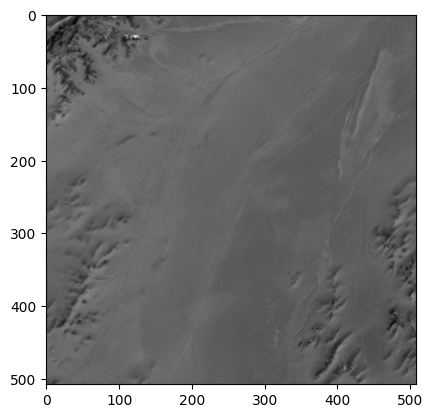

In [14]:
# Read a sample
sample_idx = 500 # Just change this!
lr = DATA.read(sample_idx).read(0)
hr = DATA.read(sample_idx).read(1)

# Retrieve the data
with rio.open(lr) as src, rio.open(hr) as dst:
    lr_data = src.read([4, 3, 2],window=rio.windows.Window(0, 0, 508, 508))
    hr_data = dst.read(window=rio.windows.Window(0, 0, 508, 508))

mash_colour_channel(torch.from_numpy(lr_data))

2025-10-06 18:56:15,681 __main__ INFO:	The image resolution is (508, 508)
2025-10-06 18:56:15,682 __main__ INFO:	The number of colour channels are 13


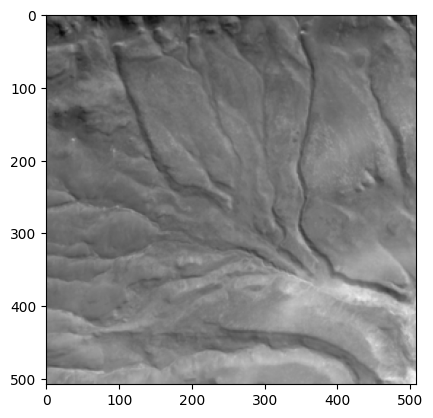

2025-10-06 18:56:15,934 __main__ INFO:	The image resolution is (508, 508)
2025-10-06 18:56:15,935 __main__ INFO:	The number of colour channels are 13


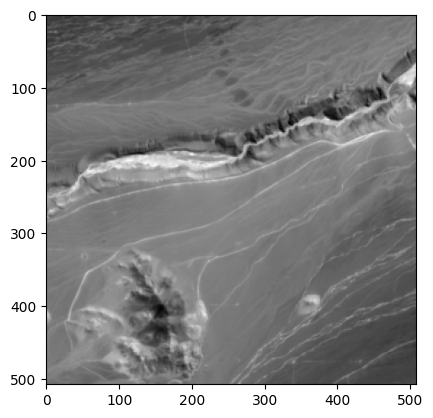

In [15]:
def extract_data(sample_idx):
  # Reads only 1 sample from the saved DATA dataset
  # Cannot use the SUB_DATA variable for some reason
  img_data = DATA.read(sample_idx).read(0)
  lbl_data = DATA.read(sample_idx).read(1)

  # Retrieve the data
  # with rio.open(img_data) as src, rio.open(lbl_data) as dst:
      # s2_l1c_data = src.read([4, 3, 2],window = rio.windows.Window(0, 0, 512, 512))
      # s2_label_data = dst.read(window=rio.windows.Window(0, 0, 512, 512))

  with rio.open(img_data), rio.open(lbl_data):
    # Image input is 508x508 pixels so that u-net works best
    s2_l1c_data = rio.open(img_data).read(window=rio.windows.Window(0, 0, 508, 508)) / 10_000  # (13, 512, 512) ndarray (numpy)
    s2_label_data = rio.open(lbl_data).read(window=rio.windows.Window(0, 0, 508, 508))

  # Output relevant datasets
  return s2_l1c_data, s2_label_data


img, label = extract_data(sample_idx = 4)
mash_colour_channel(torch.from_numpy(img))
# mash_colour_channel(torch.from_numpy(label))

img, label = extract_data(sample_idx = 7)
mash_colour_channel(torch.from_numpy(img))
# mash_colour_channel(torch.from_numpy(label))

In [54]:
# The code done here follows the example methodologies shown in introduction to PyTorch

# Problem breakdown and requirements:

# Need to import training data
# -> breakdown into training and testing datasets
# -> datasets must be cropped and converted into valid filetype
# Need to import labels
# -> datatype?
# -> labels must be cropped and converted into valid filetype

# Need to evaluate success and labels

# WORK IN PROGRESS
# Define the working datasets:
# TODO CHECK DIMENSIONS
# imported datasets are: img [z,x,y,i?], labels [x,y,i?]

# Relies on assumptions of the quality of the imported data

# PLACEHOLDER
# img_in = s2_l1c_data
# label_in = s2_label_data

# Train and testing ratio
DATASET_AMOUNT = 100
TRAIN_AMOUNT = int(DATASET_AMOUNT * tt_ratio)
TEST_AMOUNT = DATASET_AMOUNT - TRAIN_AMOUNT

tt_ratio = 0.8

# Preallocate memory for traing and testing datasets
train_img = numpy.empty(shape = (TRAIN_AMOUNT, 13, 508, 508))
train_img.fill(None)

train_label = numpy.empty(shape = (TRAIN_AMOUNT, 508, 508))
train_label.fill(None)

test_img = numpy.empty(shape = (TEST_AMOUNT, 13, 508, 508,))
test_img.fill(None)

test_label = numpy.empty(shape = (TEST_AMOUNT, 508, 508,))
test_label.fill(None)


for i in range(DATASET_AMOUNT):
  img_in, label_in = extract_data(sample_idx = i)

  # DEBUGGING image retrieval
  # mash_colour_channel(torch.from_numpy(label_in)) # comment out - for testing purposes TODO

  # store into training and testing
  if i < TRAIN_AMOUNT:
    train_img[i][:][:][:] = img_in
    train_label[i][:][:] = label_in
    print(i, "train")
  else:
    test_img[i - TRAIN_AMOUNT][:][:][:]  = img_in
    test_label[i  - TRAIN_AMOUNT][:][:] = label_in
    print(i, "test")

  tensor_info(torch.from_numpy(train_img), "combined train_img data")
  tensor_info(torch.from_numpy(test_img), "combined test_img data")

# Convert to tensors!
train_img = torch.from_numpy(train_img)
train_label = torch.from_numpy(train_label)
test_img = torch.from_numpy(test_img)
test_label = torch.from_numpy(test_label)

# -----------------------------------------------------------------------------------------------------------
# # Accessing data recommendations: "https://colab.research.google.com/drive/1U9n40rwdnn73bdWruONA3hIs1-H3f74Q"

2025-10-06 20:25:46,610 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:46,617 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:46,621 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:46,623 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:46,630 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:46,640 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:46,642 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:46,644 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:46,647 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:46,651 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:46,769 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:46,771 __main__ INFO:	Output Datatype:	torch.float64


0 train
1 train


2025-10-06 20:25:46,823 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:46,827 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:46,976 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:46,979 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:46,981 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:46,984 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:46,987 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:47,000 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:47,013 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:47,019 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:47,022 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:47,023 __main__ INFO:	Output Device:		cpu


2 train
3 train


2025-10-06 20:25:47,235 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:47,236 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:47,237 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:47,238 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:47,239 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:47,239 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:47,240 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:47,241 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:47,242 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:47,242 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:47,300 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:47,301 __main__ INFO:	Output Datatype:	torch.float64


4 train
5 train
6 train
7 train


2025-10-06 20:25:47,436 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:47,438 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:47,440 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:47,442 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:47,444 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:47,445 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:47,447 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:47,448 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:47,449 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:47,508 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:47,510 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:47,510 __main__ INFO:	Output Shape:		torch.Size([80, 13,

8 train
9 train
10 train
11 train


2025-10-06 20:25:47,710 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:47,710 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:47,771 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:47,772 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:47,773 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:47,774 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:47,775 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:47,775 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:47,777 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:47,777 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:47,778 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:47,778 __main__ INFO:	Output Device:		cpu


12 train
13 train
14 train
15 train


2025-10-06 20:25:47,974 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:47,974 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:47,975 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:48,036 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:48,038 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:48,038 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:48,039 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:48,040 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:48,040 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:48,041 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:48,042 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:48,042 __main__ INFO:	Output Size:		torch

16 train
17 train
18 train


2025-10-06 20:25:48,241 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:48,245 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:48,246 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:48,250 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:48,251 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:48,358 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:48,359 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:48,361 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:48,362 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:48,363 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:48,366 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:48,371 __main__ INFO:	Output Datatype:	torch.float64
2

19 train


2025-10-06 20:25:48,491 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:48,492 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:48,494 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:48,497 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:48,501 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:48,509 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:48,515 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:48,540 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:48,541 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:48,545 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------



20 train


2025-10-06 20:25:48,669 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:48,673 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:48,674 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:48,676 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:48,685 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:48,688 __main__ INFO:	Tensor:			combined test_img data


21 train


2025-10-06 20:25:48,699 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:48,702 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:48,707 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:48,708 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:48,797 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:48,798 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:48,801 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:48,802 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:48,803 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:48,805 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:48,806 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:48,807 __main__ INFO:	Output Shape:		torch.Size([20, 13,

22 train
23 train


2025-10-06 20:25:48,870 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:48,871 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:48,872 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:48,873 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:48,873 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:48,874 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:48,935 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:48,936 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:48,939 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:48,940 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:48,941 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:48,943 __

24 train


2025-10-06 20:25:49,004 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:49,005 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:49,006 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:49,008 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:49,008 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:49,010 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:49,011 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:49,012 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:49,013 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:49,014 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:49,082 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:49,084 __main__ INFO:	Output Datatype:	torch.float64


25 train
26 train


2025-10-06 20:25:49,149 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:49,150 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:49,151 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:49,154 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:49,155 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:49,156 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:49,157 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:49,158 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:49,161 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:49,162 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------



27 train


2025-10-06 20:25:49,231 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:49,232 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:49,234 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:49,234 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:49,235 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:49,236 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:49,236 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:49,237 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:49,238 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:49,238 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:49,303 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:49,304 __main__ INFO:	Output Datatype:	torch.float64


28 train
29 train


2025-10-06 20:25:49,378 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:49,379 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:49,380 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:49,381 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:49,382 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:49,383 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:49,384 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:49,386 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:49,387 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:49,388 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------



30 train


2025-10-06 20:25:49,450 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:49,452 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:49,454 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:49,456 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:49,459 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:49,460 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:49,462 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:49,463 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:49,464 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:49,467 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:49,531 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:49,532 __main__ INFO:	Output Datatype:	torch.float64


31 train
32 train


2025-10-06 20:25:49,605 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:49,606 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:49,607 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:49,607 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:49,608 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:49,608 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:49,609 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:49,610 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:49,610 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:49,611 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------



33 train


2025-10-06 20:25:49,675 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:49,676 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:49,677 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:49,678 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:49,678 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:49,679 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:49,680 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:49,681 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:49,681 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:49,683 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:49,795 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:49,805 __main__ INFO:	Output Datatype:	torch.float64


34 train
35 train


2025-10-06 20:25:49,813 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:49,817 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:49,822 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:49,825 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:49,829 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:49,830 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:49,837 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:49,838 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:49,946 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:49,947 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:49,950 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:49,952 __main__ INFO:	Output Size:		torch

36 train


2025-10-06 20:25:50,085 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:50,086 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:50,087 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:50,090 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:50,092 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:50,094 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:50,095 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:50,100 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:50,101 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:50,106 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------



37 train


2025-10-06 20:25:50,279 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:50,280 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:50,283 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])


38 train


2025-10-06 20:25:50,286 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:50,288 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:50,293 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:50,294 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:50,299 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:50,301 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:50,309 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:50,410 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:50,411 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:50,412 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:50,415 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:50,418 __main__ INFO:	Output Device:		cpu


39 train


2025-10-06 20:25:50,485 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:50,486 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:50,488 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:50,489 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:50,492 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:50,495 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:50,496 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:50,496 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:50,498 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:50,501 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:50,558 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:50,559 __main__ INFO:	Output Datatype:	torch.float64


40 train
41 train


2025-10-06 20:25:50,631 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:50,632 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:50,633 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:50,635 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:50,636 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:50,636 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:50,638 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:50,639 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:50,640 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:50,640 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------



42 train


2025-10-06 20:25:50,701 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:50,701 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:50,704 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:50,704 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:50,705 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:50,706 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:50,707 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:50,708 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:50,709 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:50,710 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:50,774 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:50,775 __main__ INFO:	Output Datatype:	torch.float64


43 train
44 train


2025-10-06 20:25:50,849 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:50,850 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:50,852 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:50,854 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:50,855 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:50,857 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:50,859 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:50,860 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:50,863 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:50,864 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------



45 train


2025-10-06 20:25:50,921 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:50,922 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:50,923 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:50,926 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:50,927 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:50,929 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:50,930 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:50,931 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:50,931 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:50,932 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:50,994 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:50,995 __main__ INFO:	Output Datatype:	torch.float64


46 train
47 train


2025-10-06 20:25:51,078 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:51,079 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:51,080 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:51,083 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:51,084 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:51,087 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:51,088 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:51,090 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:51,092 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:51,096 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------



48 train


2025-10-06 20:25:51,160 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:51,161 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:51,163 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:51,164 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:51,165 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:51,167 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:51,170 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:51,172 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:51,176 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:51,177 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:51,236 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:51,237 __main__ INFO:	Output Datatype:	torch.float64


49 train
50 train


2025-10-06 20:25:51,329 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:51,332 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:51,334 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:51,338 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:51,341 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:51,346 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:51,349 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:51,357 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])


51 train


2025-10-06 20:25:51,361 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:51,364 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:51,498 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:51,499 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:51,510 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:51,517 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:51,518 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:51,519 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:51,522 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:51,524 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:51,527 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])


52 train


2025-10-06 20:25:51,530 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:51,672 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:51,674 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:51,683 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:51,685 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:51,688 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:51,689 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:51,694 __main__ INFO:	Output Datatype:	torch.float64


53 train


2025-10-06 20:25:51,698 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:51,702 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:51,703 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:51,823 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:51,824 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:51,833 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:51,840 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:51,842 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:51,844 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:51,850 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:51,852 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:51,854 __main__ INFO:	Output Size:		torch

54 train


2025-10-06 20:25:51,975 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:51,977 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:51,981 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:51,983 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:51,985 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:51,990 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:51,992 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:51,994 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:51,998 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:52,002 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------



55 train


2025-10-06 20:25:52,119 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:52,120 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:52,121 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:52,123 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:52,125 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:52,129 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:52,131 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:52,134 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:52,137 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:52,140 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------



56 train


2025-10-06 20:25:52,200 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:52,202 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:52,204 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:52,205 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:52,207 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:52,208 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:52,209 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:52,210 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:52,211 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:52,212 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:52,278 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:52,279 __main__ INFO:	Output Datatype:	torch.float64


57 train
58 train


2025-10-06 20:25:52,361 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:52,362 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:52,363 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:52,364 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:52,364 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:52,365 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:52,366 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:52,366 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:52,367 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:52,368 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------



59 train


2025-10-06 20:25:52,435 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:52,435 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:52,437 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:52,439 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:52,441 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:52,443 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:52,444 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:52,446 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:52,447 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:52,447 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:52,510 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:52,511 __main__ INFO:	Output Datatype:	torch.float64


60 train
61 train


2025-10-06 20:25:52,589 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:52,590 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:52,591 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:52,592 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:52,594 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:52,595 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:52,598 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:52,599 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:52,602 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:52,604 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------



62 train


2025-10-06 20:25:52,662 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:52,662 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:52,665 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:52,667 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:52,669 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:52,671 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:52,672 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:52,674 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:52,675 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:52,677 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:52,739 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:52,740 __main__ INFO:	Output Datatype:	torch.float64


63 train
64 train


2025-10-06 20:25:52,825 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:52,826 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:52,827 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:52,828 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:52,829 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:52,830 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:52,831 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:52,833 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:52,834 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:52,834 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------



65 train


2025-10-06 20:25:52,899 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:52,900 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:52,901 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:52,903 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:52,904 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:52,906 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:52,908 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:52,909 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:52,911 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:52,913 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:53,022 __main__ INFO:	Tensor:			combined train_img data


66 train
67 train


2025-10-06 20:25:53,031 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:53,047 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:53,054 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:53,061 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:53,077 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:53,083 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:53,085 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:53,087 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:53,089 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:53,259 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:53,260 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:53,263 __main__ INFO:	Output Shape:		torch.Size([80, 13,

68 train


2025-10-06 20:25:53,521 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:53,522 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:53,523 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:53,527 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:53,529 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:53,535 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:53,539 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:53,542 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:53,546 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:53,550 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------



69 train


2025-10-06 20:25:53,726 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:53,726 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:53,727 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:53,730 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:53,733 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:53,734 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:53,734 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:53,736 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:53,740 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:53,740 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------



70 train


2025-10-06 20:25:53,888 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:53,889 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:53,889 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:53,890 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:53,891 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:53,891 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:53,892 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:53,892 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:53,893 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:53,894 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------



71 train


2025-10-06 20:25:53,961 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:53,963 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:53,963 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:53,964 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:53,965 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:53,965 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:53,966 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:53,967 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:53,967 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:53,968 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:54,037 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:54,038 __main__ INFO:	Output Datatype:	torch.float64


72 train
73 train


2025-10-06 20:25:54,121 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:54,122 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:54,125 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:54,125 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:54,126 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:54,127 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:54,128 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:54,129 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:54,130 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:54,130 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------



74 train


2025-10-06 20:25:54,203 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:54,204 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:54,205 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:54,205 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:54,206 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:54,207 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:54,207 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:54,208 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:54,208 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:54,209 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:54,277 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:54,278 __main__ INFO:	Output Datatype:	torch.float64


75 train
76 train


2025-10-06 20:25:54,353 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:54,354 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:54,354 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:54,355 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:54,356 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:54,356 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:54,357 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:54,358 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:54,358 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:54,359 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------



77 train


2025-10-06 20:25:54,427 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:54,428 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:54,429 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:54,429 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:54,430 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:54,430 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:54,431 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:54,432 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:54,433 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:54,434 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:54,520 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:54,522 __main__ INFO:	Output Datatype:	torch.float64


78 train
79 train


2025-10-06 20:25:54,618 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:54,619 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:54,623 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:54,627 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])


80 test


2025-10-06 20:25:54,629 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:54,630 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:54,635 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:54,636 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:54,638 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:54,640 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:54,775 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:54,776 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:54,780 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:54,781 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:54,791 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:54,792 __

81 test


2025-10-06 20:25:54,976 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:54,977 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:54,979 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:54,980 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:54,981 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:54,985 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:54,985 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:54,986 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:54,988 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:54,990 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------



82 test


2025-10-06 20:25:55,108 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:55,109 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:55,110 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:55,112 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:55,112 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:55,113 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:55,114 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:55,115 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:55,116 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:55,116 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------



83 test


2025-10-06 20:25:55,201 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:55,205 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:55,206 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:55,206 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:55,209 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:55,210 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:55,210 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:55,213 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:55,213 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:55,221 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------



84 test


2025-10-06 20:25:55,389 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:55,391 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:55,392 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:55,393 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:55,395 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:55,395 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:55,397 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:55,399 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])


85 test


2025-10-06 20:25:55,402 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:55,403 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:55,573 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:55,581 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:55,582 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:55,583 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])


86 test


2025-10-06 20:25:55,583 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:55,584 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:55,585 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:55,586 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:55,587 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:55,587 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:55,668 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:55,669 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:55,670 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:55,671 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:55,672 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:55,672 __

87 test
88 test


2025-10-06 20:25:55,839 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:55,840 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:55,841 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:55,843 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:55,843 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:55,844 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:55,845 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:55,846 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:55,846 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:55,847 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------



89 test


2025-10-06 20:25:55,936 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:55,937 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:55,938 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:55,940 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:55,940 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:55,941 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:55,942 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:55,942 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:55,943 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:55,943 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:56,033 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:56,034 __main__ INFO:	Output Datatype:	torch.float64


90 test
91 test


2025-10-06 20:25:56,039 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:56,040 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:56,108 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:56,109 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:56,110 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:56,110 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:56,111 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:56,112 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:56,112 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:56,113 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:56,114 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:56,115 __main__ INFO:	Output Device:		cpu


92 test


2025-10-06 20:25:56,200 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:56,201 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:56,202 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:56,202 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:56,203 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:56,204 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:56,205 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:56,206 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:56,207 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:56,207 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:56,274 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:56,276 __main__ INFO:	Output Datatype:	torch.float64


93 test
94 test


2025-10-06 20:25:56,354 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:56,355 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:56,356 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:56,357 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:56,358 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:56,358 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:56,359 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:56,360 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:56,363 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:56,364 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------



95 test


2025-10-06 20:25:56,526 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:56,527 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:56,530 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:56,531 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:56,534 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:56,535 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:56,539 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:56,547 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:56,548 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:56,552 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------



96 test


2025-10-06 20:25:56,714 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:56,720 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:56,724 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:56,725 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])


97 test


2025-10-06 20:25:56,728 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:56,747 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:56,749 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:56,750 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:56,752 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:56,753 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:56,936 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:56,937 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:56,938 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:56,941 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:56,943 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:56,945 __

98 test


2025-10-06 20:25:57,143 __main__ INFO:	Tensor:			combined train_img data
2025-10-06 20:25:57,144 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:57,149 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:57,149 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-06 20:25:57,152 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:25:57,154 __main__ INFO:	Tensor:			combined test_img data
2025-10-06 20:25:57,159 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:25:57,160 __main__ INFO:	Output Shape:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:57,167 __main__ INFO:	Output Size:		torch.Size([20, 13, 508, 508])
2025-10-06 20:25:57,168 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------



99 test


2025-10-06 20:26:40,164 __main__ INFO:	Tensor:			img_bundle_name 1
2025-10-06 20:26:40,167 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:26:40,168 __main__ INFO:	Output Shape:		torch.Size([13, 508, 508])
2025-10-06 20:26:40,169 __main__ INFO:	Output Size:		torch.Size([13, 508, 508])
2025-10-06 20:26:40,171 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:26:40,181 __main__ INFO:	The image resolution is (508, 508)
2025-10-06 20:26:40,182 __main__ INFO:	The number of colour channels are 13


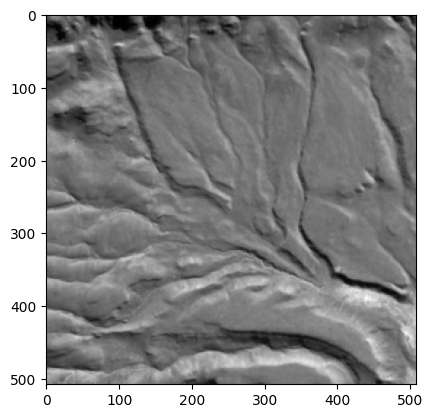

2025-10-06 20:26:40,497 __main__ INFO:	Tensor:			img_bundle_name 7
2025-10-06 20:26:40,501 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:26:40,502 __main__ INFO:	Output Shape:		torch.Size([13, 508, 508])
2025-10-06 20:26:40,505 __main__ INFO:	Output Size:		torch.Size([13, 508, 508])
2025-10-06 20:26:40,506 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:26:40,520 __main__ INFO:	The image resolution is (508, 508)
2025-10-06 20:26:40,523 __main__ INFO:	The number of colour channels are 13


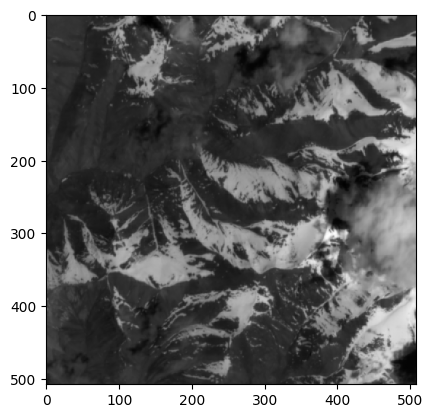

2025-10-06 20:26:40,797 __main__ INFO:	Tensor:			img_bundle_name 19
2025-10-06 20:26:40,798 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:26:40,800 __main__ INFO:	Output Shape:		torch.Size([13, 508, 508])
2025-10-06 20:26:40,800 __main__ INFO:	Output Size:		torch.Size([13, 508, 508])
2025-10-06 20:26:40,801 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:26:40,808 __main__ INFO:	The image resolution is (508, 508)
2025-10-06 20:26:40,810 __main__ INFO:	The number of colour channels are 13


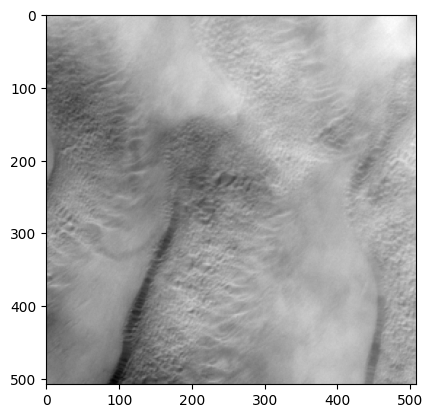

2025-10-06 20:26:41,027 __main__ INFO:	Tensor:			img_bundle_name 79
2025-10-06 20:26:41,030 __main__ INFO:	Output Datatype:	torch.float64
2025-10-06 20:26:41,030 __main__ INFO:	Output Shape:		torch.Size([13, 508, 508])
2025-10-06 20:26:41,031 __main__ INFO:	Output Size:		torch.Size([13, 508, 508])
2025-10-06 20:26:41,032 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-06 20:26:41,039 __main__ INFO:	The image resolution is (508, 508)
2025-10-06 20:26:41,040 __main__ INFO:	The number of colour channels are 13


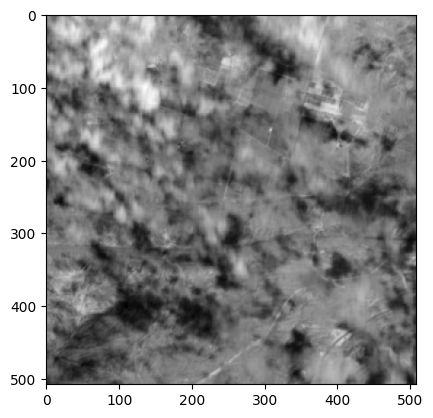

In [57]:
# to delete
#[train_img, train_label, test_img, test_label]



def view_img(index_i, img_bundle, img_bundle_name):
  tensor_info(img_bundle[index_i][:][:][:], "img_bundle_name " + str(index_i))
  mash_colour_channel(img_bundle[index_i][:][:][:])

view_img(1, train_img, "train_img")
view_img(7, test_img, "test_img")
view_img(19, test_img, "test_img")
view_img(79, train_img, "train_img")

todo 02.10.2025 Thursday W8+1

Tried to save data the "stupidest" way possible. Iterate through a dataset - get data individually and then load data to a common array variable.

problems:
- incorrect datatype -  need a numpy object of a certain size/parameters
- need to collect imgs into single item - missing dimensions from bad appending
- need to seperate between training and testing - do after the main dataset variable is created.

- need to sort: geogrpahically, camerawise etc.

Codebase is completed under "stupid" method.

In [58]:
TRAINING_LENGTH = 200 # CONTROLS NUMBER OF TRAINING CYCLES


# Allow for parameters of model to be randomised.
weights = nn.Parameter(
    torch.randn(1, dtype = torch.float32),
    requires_grad = True
  )

# Model inferencing (making predictions) - TODO REMOVE IF UNNECESSARY
# with torch.inference_mode():
#   prediction = u_net_arch(img_test) # Can manually check the predictions

# loss and optimiser functions
loss_fn = nn.L1Loss() # TODO MAE loss is same as L1Loss
optimiser_fn = torch.optim.SGD(
    params = u_net_arch.parameters(), # parameters to be optimised
    lr = 0.01 # learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))
)

# location and storage of loss values

for epoch in range(TRAINING_LENGTH):
  u_net_arch.train() # In Training Mode - Default

  label_predict = u_net_arch(train_img) # intiial forward pass of model

  loss = loss_fn(label_predict, train_label) # loss value is generated

  optimiser_fn.zero_grad() # optimised via zero grad

  loss.backward() # loss back propagation

  optimiser_fn.step() # progress the optimiser

  # Evaluate and test the model
  u_net_arch.eval()

  with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = u_net_arch(test_img)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, label_test.type(torch.float32)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

# Find our model's learned parameters
print("The model learned parameters:")
print(u_net_arch.state_dict())

RuntimeError: Input type (double) and bias type (float) should be the same

In [ ]:
u_net_arch.eval()

# Making a prediction - use to evaluate the validity of the dataset
with torch.inference_mode():
  label_preds = u_net_arch(img_test)

# create graphical method of visualising code

In [ ]:
# Print off images and their respective dimensions
"""
# Visualising the results along with their respective dimensions

# Print off image with the colour channels combined
# First Image
mash_colour_channel(s2_l1c_data_tensor) # Original image

# Encoder Images
mash_colour_channel(A_pooled)
mash_colour_channel(B_pooled)
mash_colour_channel(C_pooled)
mash_colour_channel(D_pooled)

mash_colour_channel(E_bottleneck)

# Decoder Images
mash_colour_channel(D_deconv)
mash_colour_channel(C_deconv)
mash_colour_channel(B_deconv)
mash_colour_channel(A_deconv)

# Final image
mash_colour_channel(Final_output)

# Encoder
tensor_info(s2_l1c_data_tensor, "layer 0 - s2_l1c_data_tensor")
tensor_info(A_concat, "encoder_layer_0.5 - A_concat")
tensor_info(A_pooled, "encoder_layer_1 - A_pooled")
tensor_info(B_concat, "encoder_layer_1.5 - B_concat")
tensor_info(B_pooled, "encoder_layer_2 - B_pooled")
tensor_info(C_concat, "encoder_layer_2.5 - C_concat")
tensor_info(C_pooled, "encoder_layer_3 - C_pooled")
tensor_info(D_concat, "encoder_layer_4.5 - D_concat")
tensor_info(D_pooled, "encoder_layer_4 - D_pooled") # size [208, 28, 28] - final layer

tensor_info(E_bottleneck, "[BOTTLENECK] encoder_layer_5")

# Decoder
tensor_info(D_deconv, "decoder_layer_4 - D_deconv")
tensor_info(C_deconv, "encoder_layer_3 - C_deconv")
tensor_info(B_deconv, "encoder_layer_2 - B_deconv")
tensor_info(A_deconv, "encoder_layer_1 - A_deconv")
tensor_info(Final_output, "Final output")
"""

## todo:

main requirements:
1. *work out how to transfer images and visualise progress*
2. determine required images and what I should use
---
Datahandling:

1. > Need to determine how to import multiple datavalues
2. > Need to determine how many training and testing datasets there are
3. > Need to determine method of seperating datasets
4. > Need to determine if subset / SUB_DATA methodology works.

Do I need to create a proper datahandler?

---

3. being to save progress with model fitting
4. make the model tech agnostic
5. Get a logger setup - requires a working file directory
```
import logging
self.logger = logging.getLogger(__name__)
```
## todo big picture:
1. **DONE!** get rough model working
2. **DONE!** build the Unet model

##Useful knowledge:
1. keyboard shortcut to comment and uncomment out things is ctrl + "/"
2. The U-net model requires that the encoder/decoder colour channel follows the following pattern: 1 - 64 - 128 - 256 - 512
3. Refer to "https://stackoverflow.com/questions/57530038/concatenation-step-of-u-net-for-unequal-number-of-channels" for more information

## CloudSEN12+ dataset information:
(Further information about CloudSEN12+ dataset)

1. The Huggingface website: https://huggingface.co/datasets/tacofoundation/cloudsen12
Explains the overall picture of the dataset types

2. https://www.scidb.cn/en/detail?dataSetId=2036f4657b094edfbb099053d6024b08&version=V1
Explains historical dataset formatting - we are interested in  p509 has some further details. Investigate: *p509-> high -> train*

## Additional References:

Sam Hall's References:
- OBAI Cloud Detection tutorial: https://source.coop/radiantearth/cloud-cover-detection-challenge
- OBAI recommendations indpendent of ECSS: https://ieeexplore.ieee.org/document/10558221